#Importación de Librerias

In [3]:
#Subir documento con el nombre "gob_chats.txt"
!pip install pandas
!pip install openpyxl
!pip install geopy
!pip install fuzzywuzzy
!pip install requests
!pip install cdsapi

In [4]:
import ast
import cdsapi
import os
import re
import pandas as pd
import time
import random
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from datetime import datetime, timedelta
from fuzzywuzzy import fuzz
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, \
OneHotEncoder
from sklearn.model_selection import train_test_split, \
cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor,\
 GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from xgboost import XGBRegressor


/usr/local/lib/python3.12/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Importación de Datos

In [ ]:
geotest_df = pd.read_csv('servicios.csv')

In [ ]:
geotest_df.head()

,FECHA,HORA,UBICACION
0,2023-10-26,22:28:00,NaN
1,2023-10-26,22:34:00,PARA VALORIZACION DE FEMENINA
2,2023-10-26,23:17:00,NaN
3,2023-10-27,00:28:00,NaN
4,2023-10-27,01:44:00,NaN


## Se observa la inicial del dataset:
### Se muestran número de registros, los tipos de datos y los posibles valores faltantes.

In [ ]:
geotest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18673 entries, 0 to 18672
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FECHA      18673 non-null  object
 1   HORA       18673 non-null  object
 2   UBICACION  16990 non-null  object
dtypes: object(3)
memory usage: 437.8+ KB


## Se eliminan filas con valores faltantes.
### Esto debido a que el enfoque principal del proyecto es la predicción de coordenadas, por lo que es más conveniente deshacernos de las incompletas que completar la información faltante por medio de promedios u otras tecnicas alternativas

In [ ]:
geotest_df = geotest_df.dropna()

In [ ]:
geotest_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16990 entries, 1 to 18667
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FECHA      16990 non-null  object
 1   HORA       16990 non-null  object
 2   UBICACION  16990 non-null  object
dtypes: object(3)
memory usage: 530.9+ KB


In [ ]:
# Se crea la columna 'COORDENADAS'
geotest_df['COORDENADAS'] = geotest_df.get('COORDENADAS')

In [ ]:
geotest_df.shape

(16990, 4)

In [ ]:
geotest_df.head()

,FECHA,HORA,UBICACION,COORDENADAS
1,2023-10-26,22:34:00,PARA VALORIZACION DE FEMENINA,None
5,2023-10-27,08:09:00,MANANTIAL 507 LAGO COLONIA EL MANANTI...,None
6,2023-10-27,08:19:00,ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN ...,None
7,2023-10-27,08:41:00,CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...,None
8,2023-10-27,09:10:00,ELIAS FLORES SUR GARZA GARCIA OTE CO...,None


In [ ]:
geotest_df.tail()

,FECHA,HORA,UBICACION,COORDENADAS
18663,2025-05-12,00:13:00,RIO GUADIANA RIO PARAGUAY RIO PARAGUAY 845 25...,None
18664,2025-05-12,02:21:00,E 6A SAN FELIPE Colonia VALLE DE SAN ANDRES ...,None
18665,2025-05-12,04:01:00,VALLE DEL MAIZ 835 Colonia VALLE DE L...,None
18666,2025-05-12,06:30:00,BOSQUE NOGAL BOSQUE PALMITO 25 72327 100 158...,None
18667,2025-05-12,07:54:00,SOLO LE MENCIONAN QUE SE SIENTE MAL REQUIERE A...,None


## Se convierte ubicación a coordenada
### Se utiliza un api para procesar las ubicaciones y convertirlas a coordenadas y exportandolo a 'geotest_backup.csv'

In [ ]:
# Configurar geolocalizador
geolocator = Nominatim(user_agent="MIATest/1.0", timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Palabras irrelevantes o ruido
STOPWORDS = [
    r"\bCOLONIA\b", r"\bCORRODENAADAS\b", r"\bCOORDENADAS\b",
    r"\bAPODACA\b", r"\bNL\b", r"\bMUNICIPIO\b", r"\bIGLESIA\b",
    r"\bFOM\b", r"\bKM\b", r"\bPUENTE\b", r"\bPUEBLO\b"
]

def limpiar_direccion(direccion):
    # Quitar palabras innecesarias
    for palabra in STOPWORDS:
        direccion = re.sub(palabra, '', direccion, flags=re.IGNORECASE)
    # Eliminar múltiples espacios y comas repetidas
    direccion = re.sub(r'\s+', ' ', direccion).strip()
    direccion = re.sub(r'[^\w\s#\-,]', '', direccion)
    # Añadir contexto geográfico si falta
    direccion = direccion.strip(', ')
    if 'apodaca' not in direccion.lower():
        direccion += ', Apodaca, Nuevo León, México'
    elif 'nuevo león' not in direccion.lower():
        direccion += ', Nuevo León, México'
    elif 'méxico' not in direccion.lower():
        direccion += ', México'
    return direccion

def reduce_address(address, level):
    parts = address.split(', ')
    return ', '.join(parts[level:]) if len(parts) > level else address

start_time = time.time()
counter = 0
total_addresses = len(geotest_df)

def geocode_address(address, existing_coords, folio, counter, total_addresses):
    if existing_coords is not None and existing_coords != (None, None):
        return existing_coords, counter
    try:
        direccion_limpia = limpiar_direccion(address)
        location = None
        for level in range(3):  # Intenta con niveles de reducción
            query = reduce_address(direccion_limpia, level)
            location = geocode(query)
            if location:
                break
        if location:
            result = {'lat': location.latitude, 'lon': location.longitude}
        else:
            print(f"⚠️ No se encontró dirección: {folio} -> '{address}'")
            result = None
    except (GeocoderTimedOut, GeocoderUnavailable) as e:
        print(f"⏱️ Timeout/Unavailable en folio {folio}: {e}")
        result = None
    except Exception as e:
        print(f"❌ Error general en folio {folio}: {e}")
        result = None
    counter += 1
    print(f"✅ Coordenada para folio {folio}: {result}")
    # Progreso y backup cada 50
    if counter % 50 == 0:
        elapsed = time.time() - start_time
        remaining = total_addresses - counter
        avg_time = elapsed / counter
        est_time_left = avg_time * remaining
        print(f"📊 {counter}/{total_addresses} procesados. "
              f"Tiempo estimado restante: {est_time_left/60:.2f} min")
        geotest_df.to_csv("geotest_backup.csv", index=False)
        print("💾 Backup guardado.")
    return result, counter

def apply_geocoding(row):
    global counter
    coord, counter = geocode_address(
        row['UBICACION'],
        row.get('COORDENADAS', None),
        row.get('FOLIO', row['UBICACION']),
        counter,
        total_addresses
    )
    return coord

# Aplicar geocodificación
geotest_df['COORDENADAS'] = geotest_df.apply(apply_geocoding, axis=1)

# Guardar resultado final
geotest_df.to_csv("geotest_backup.csv", index=False)
print("✅ Geocodificación finalizada. Backup guardado.")



Streaming output truncated to the last 5000 lines.
✅ Coordenada para folio TREVINO 1095        COLONIA  CENTRO DE APODACA APODACA NL: {'lat': 25.7789998, 'lon': -100.2004012}
✅ Coordenada para folio LMTO NOROESTE E KM 35 544  CORRODENAADAS  25 83111  100 25400   COLONIA  MUNICIPIO DE APODACA APODACA NL   IGLESIA CENTRO MUNDIAL DE ORACION: {'lat': 25.7871006, 'lon': -100.1850769}
✅ Coordenada para folio JAPON 203   COLONIA  NUEVO AMANECER 2 APODACA NL: {'lat': 25.7715892, 'lon': -100.2463403}
✅ Coordenada para folio AV TREBOLES AV 7A        COLONIA  LOS TREBOLES APODACA NL: {'lat': 25.7871006, 'lon': -100.1850769}
✅ Coordenada para folio BOLIVIA 106       COLONIA    NUEVO AMANECER 1 APODACA NL: {'lat': 25.7871006, 'lon': -100.1850769}
✅ Coordenada para folio AV NUEVA LAS PUENTES ZINC        COLONIA  AV NUEVA LAS PUENTES ZINC: {'lat': 25.7871006, 'lon': -100.1850769}
✅ Coordenada para folio CTO CLIO ALAYA  CTO CLIO 225       COLONIA  PRIVALIA CONCORDIA 1 APODACA NL: {'lat': 25.7871006, '

# Expansión de variables

### Se importa base de datos con coordenadas a 'geotest_backup.csv'

In [5]:
geotest_coordinates = pd.read_csv('geotest_backup.csv')

In [6]:
geotest_coordinates.head()

,FECHA,HORA,UBICACION,COORDENADAS
0,2023-10-26,22:34:00,PARA VALORIZACION DE FEMENINA,"{'lat': 25.7871006, 'lon': -100.1850769}"
1,2023-10-27,08:09:00,MANANTIAL 507 LAGO COLONIA EL MANANTI...,"{'lat': 25.7871006, 'lon': -100.1850769}"
2,2023-10-27,08:19:00,ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN ...,"{'lat': 25.7871006, 'lon': -100.1850769}"
3,2023-10-27,08:41:00,CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...,"{'lat': 25.7871006, 'lon': -100.1850769}"
4,2023-10-27,09:10:00,ELIAS FLORES SUR GARZA GARCIA OTE CO...,"{'lat': 25.7871006, 'lon': -100.1850769}"


## Se divide COORDENADAS en LATITUD y LONGITUD

In [8]:

# Se convierte el diccionario stringified de COORDENADAS a diccionarios reales
geotest_coordinates["COORDENADAS"] = geotest_coordinates["COORDENADAS"].apply(ast.literal_eval)

# Se divide en LATITUD y LONGITUD
geotest_coordinates["LATITUD"] = geotest_coordinates["COORDENADAS"].apply(lambda x: x.get("lat") if isinstance(x, dict) else None)
geotest_coordinates["LONGITUD"] = geotest_coordinates["COORDENADAS"].apply(lambda x: x.get("lon") if isinstance(x, dict) else None)

# Se convierten a númericos
geotest_coordinates["LATITUD"] = pd.to_numeric(geotest_coordinates["LATITUD"])
geotest_coordinates["LONGITUD"] = pd.to_numeric(geotest_coordinates["LONGITUD"])

geotest_coordinates.head()

,FECHA,HORA,UBICACION,COORDENADAS,LATITUD,LONGITUD
0,2023-10-26,22:34:00,PARA VALORIZACION DE FEMENINA,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077
1,2023-10-27,08:09:00,MANANTIAL 507 LAGO COLONIA EL MANANTI...,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077
2,2023-10-27,08:19:00,ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN ...,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077
3,2023-10-27,08:41:00,CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077
4,2023-10-27,09:10:00,ELIAS FLORES SUR GARZA GARCIA OTE CO...,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077


In [9]:
geotest_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17408 entries, 0 to 17407
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        17408 non-null  object 
 1   HORA         17408 non-null  object 
 2   UBICACION    17352 non-null  object 
 3   COORDENADAS  17408 non-null  object 
 4   LATITUD      17408 non-null  float64
 5   LONGITUD     17408 non-null  float64
dtypes: float64(2), object(4)
memory usage: 816.1+ KB


##Se eliminan las filas en las que las coordenadas correspondan a {'lat': 25.7871006, 'lon': -100.1850769}
### Esto debido a que por medio de revisión se asume que son coordenadas que se entregaron por default en los conceptos que se encontraba un texto diferente a una ubicación.

In [10]:
mask = ~(
    (geotest_coordinates["LATITUD"].round(6) == 25.787101) &
    (geotest_coordinates["LONGITUD"].round(6) == -100.185077)
)

geotest_coordinates = geotest_coordinates[mask]


### Se pierde un 70% de la información por error de descripción en base de datos o por error de la api utilizada

In [11]:
geotest_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5077 entries, 7 to 17403
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        5077 non-null   object 
 1   HORA         5077 non-null   object 
 2   UBICACION    5077 non-null   object 
 3   COORDENADAS  5077 non-null   object 
 4   LATITUD      5077 non-null   float64
 5   LONGITUD     5077 non-null   float64
dtypes: float64(2), object(4)
memory usage: 277.6+ KB


### Se hace una revisión de propiedades de LATITUD y LONGITUD y se eliminan outliers

In [12]:
geotest_coordinates.describe()

,LATITUD,LONGITUD
count,5077.000000,5077.000000
mean,25.767461,-100.202644
std,0.035788,0.045255
min,25.697963,-100.267519
25%,25.743280,-100.247144
50%,25.769828,-100.197024
75%,25.787590,-100.164143
max,26.238436,-99.887300


In [40]:
# Función para detectar y eliminar outliers con IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"{column}:")
    print(f"  Q1 = {Q1}")
    print(f"  Q3 = {Q3}")
    print(f"  IQR = {IQR}")
    print(f"  Lower bound = {lower_bound}")
    print(f"  Upper bound = {upper_bound}")

    # Filtramos
    mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    return df[mask]

# Aplicamos en LATITUD y LONGITUD
print("---- LATITUD ----")
df_no_outliers = remove_outliers_iqr(geotest_coordinates, "LATITUD")

print("---- LONGITUD ----")
df_no_outliers = remove_outliers_iqr(df_no_outliers, "LONGITUD")

print(f"\nTamaño original: {geotest_coordinates.shape[0]}")
print(f"Tamaño después de eliminar outliers: {df_no_outliers.shape[0]}")

geotest_coordinates = df_no_outliers


---- LATITUD ----
LATITUD:
  Q1 = 25.7432803
  Q3 = 25.7875899
  IQR = 0.044309600000001836
  Lower bound = 25.676815899999994
  Upper bound = 25.8540543
---- LONGITUD ----
LONGITUD:
  Q1 = -100.2471441
  Q3 = -100.1641427
  IQR = 0.08300140000000056
  Lower bound = -100.3716462
  Upper bound = -100.0396406

Tamaño original: 5077
Tamaño después de eliminar outliers: 5069


## Se expande la fecha y la hora en subconjuntos

In [41]:
geotest_coordinates["FECHA"] = geotest_coordinates["FECHA"].astype(str).str.strip()
geotest_coordinates["HORA"]  = geotest_coordinates["HORA"].astype(str).str.strip()

# Se convierte fecha y hora en los formatos adecuados
geotest_coordinates["FECHA_dt"] = pd.to_datetime(geotest_coordinates["FECHA"], format="%Y-%m-%d", errors="coerce")
mask = geotest_coordinates["FECHA_dt"].isna()
geotest_coordinates.loc[mask, "FECHA_dt"] = pd.to_datetime(geotest_coordinates.loc[mask, "FECHA"], dayfirst=True, errors="coerce")

geotest_coordinates["HORA_td"] = pd.to_timedelta(geotest_coordinates["HORA"], errors="coerce")

geotest_coordinates["DT"] = geotest_coordinates["FECHA_dt"] + geotest_coordinates["HORA_td"]
geotest_coordinates = geotest_coordinates.dropna(subset=["DT"]).reset_index(drop=True)

# Se redondea a 15 mins en columna nueva
geotest_coordinates["DT_15"] = geotest_coordinates["DT"].dt.round("15min")

# Se generan subvariables
geotest_coordinates["FECHA"]        = geotest_coordinates["DT_15"].dt.date
geotest_coordinates["HORA_15"]      = geotest_coordinates["DT_15"].dt.strftime("%H:%M")      # label like "10:15"
geotest_coordinates["HORA_H"]       = geotest_coordinates["DT_15"].dt.hour                   # 0..23
geotest_coordinates["WEEKDAY"]      = geotest_coordinates["DT_15"].dt.dayofweek              # 0=Mon .. 6=Sun
weekday_map = {0:"Lun",1:"Mar",2:"Mié",3:"Jue",4:"Vie",5:"Sáb",6:"Dom"}
geotest_coordinates["WEEKDAY_NAME"] = geotest_coordinates["WEEKDAY"].map(weekday_map)


slots = pd.date_range("00:00", "23:45", freq="15min").strftime("%H:%M")
geotest_coordinates["HORA_15"] = pd.Categorical(geotest_coordinates["HORA_15"], categories=slots, ordered=True)

geotest_coordinates["MIN_DESDE_MEDIANOCHE"] = geotest_coordinates["DT_15"].dt.hour*60 + geotest_coordinates["DT_15"].dt.minute


In [42]:
geotest_coordinates.head()

,FECHA,HORA,UBICACION,COORDENADAS,LATITUD,LONGITUD,FECHA_dt,HORA_td,DT,DT_15,HORA_15,HORA_H,WEEKDAY,WEEKDAY_NAME,MIN_DESDE_MEDIANOCHE
0,2023-10-27,10:21:00,TREVINO 1095 COLONIA CENTRO DE APODACA...,"{'lat': 25.7415877, 'lon': -100.1636989}",25.741588,-100.163699,2023-10-27,0 days 10:21:00,2023-10-27 10:21:00,2023-10-27 10:15:00,10:15,10,4,Vie,615
1,2023-10-27,11:39:00,JAPON 203 COLONIA NUEVO AMANECER 2 APODACA NL,"{'lat': 25.7715892, 'lon': -100.2463403}",25.771589,-100.246340,2023-10-27,0 days 11:39:00,2023-10-27 11:39:00,2023-10-27 11:45:00,11:45,11,4,Vie,705
2,2023-10-27,16:17:00,VIRIDIANA 123 COLONIA LOS MURALES APODAC...,"{'lat': 25.8019734, 'lon': -100.2225829}",25.801973,-100.222583,2023-10-27,0 days 16:17:00,2023-10-27 16:17:00,2023-10-27 16:15:00,16:15,16,4,Vie,975
3,2023-10-27,18:35:00,A AV,"{'lat': 25.7555529, 'lon': -100.1969985}",25.755553,-100.196999,2023-10-27,0 days 18:35:00,2023-10-27 18:35:00,2023-10-27 18:30:00,18:30,18,4,Vie,1110
4,2023-10-28,10:15:00,HACIENDA DEL MEZQUITAL APODACA NL,"{'lat': 25.7493878, 'lon': -100.2317873}",25.749388,-100.231787,2023-10-28,0 days 10:15:00,2023-10-28 10:15:00,2023-10-28 10:15:00,10:15,10,5,Sáb,615


In [43]:
geotest_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5069 entries, 0 to 5068
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   FECHA                 5069 non-null   object         
 1   HORA                  5069 non-null   object         
 2   UBICACION             5069 non-null   object         
 3   COORDENADAS           5069 non-null   object         
 4   LATITUD               5069 non-null   float64        
 5   LONGITUD              5069 non-null   float64        
 6   FECHA_dt              5069 non-null   datetime64[ns] 
 7   HORA_td               5069 non-null   timedelta64[ns]
 8   DT                    5069 non-null   datetime64[ns] 
 9   DT_15                 5069 non-null   datetime64[ns] 
 10  HORA_15               5069 non-null   category       
 11  HORA_H                5069 non-null   int32          
 12  WEEKDAY               5069 non-null   int32          
 13  WEE

## Se exporta base expandida a 'geotest_w_coordinates.csv'

In [44]:
geotest_coordinates.to_csv('geotest_w_coordinates.csv', index=False)
# Confirm the save operation
print("geotest_coordinates saved successfully.")

geotest_coordinates saved successfully.


# Gráficas exploratorias

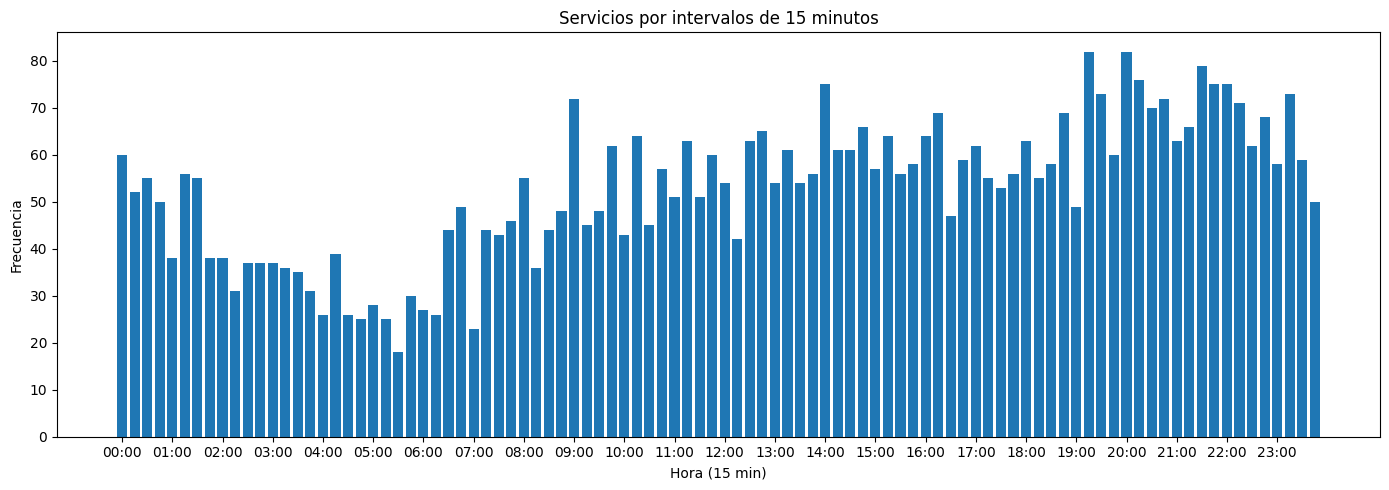

In [45]:
counts_15 = geotest_coordinates["HORA_15"].value_counts().sort_index()
ticks = np.arange(0, 96, 4)

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(counts_15)), counts_15.values)
plt.title("Servicios por intervalos de 15 minutos")
plt.xlabel("Hora (15 min)")
plt.ylabel("Frecuencia")
plt.xticks(ticks, slots[ticks], rotation=0)
plt.tight_layout(); plt.show()


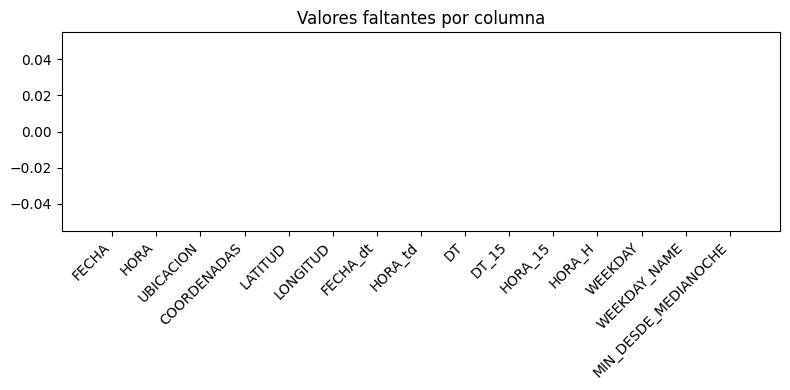

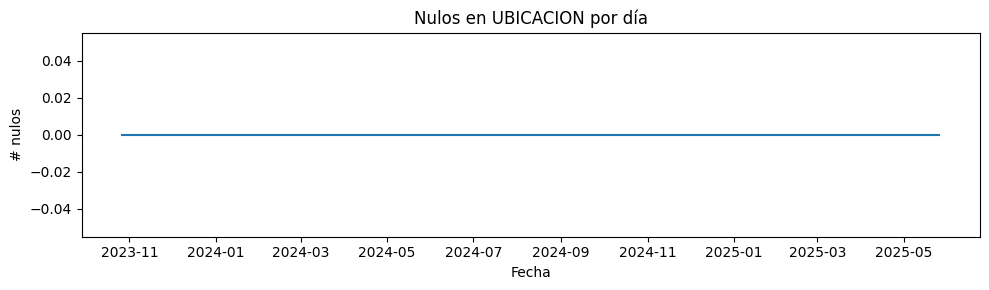

In [46]:
# Conteo de nulos por columna
na_counts = geotest_coordinates.isna().sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
plt.bar(na_counts.index, na_counts.values)
plt.title("Valores faltantes por columna")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# Mapa de ausencia por día (nulos en UBICACION como ejemplo)
by_day_na = geotest_coordinates.set_index("DT_15").resample("D")["UBICACION"].apply(lambda s: s.isna().sum())
plt.figure(figsize=(10,3))
plt.plot(by_day_na.index, by_day_na.values)
plt.title("Nulos en UBICACION por día"); plt.xlabel("Fecha"); plt.ylabel("# nulos")
plt.tight_layout(); plt.show()


           LATITUD     LONGITUD  MIN_DESDE_MEDIANOCHE
count  5069.000000  5069.000000           5069.000000
mean     25.766939  -100.202932            796.041626
std       0.032530     0.044184            409.918045
min      25.697963  -100.267519              0.000000
25%      25.743280  -100.247144            495.000000
50%      25.769828  -100.197059            840.000000
75%      25.787590  -100.164143           1155.000000
max      25.840453  -100.106510           1425.000000


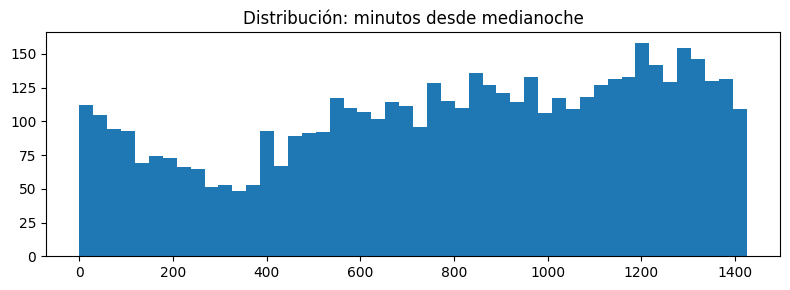

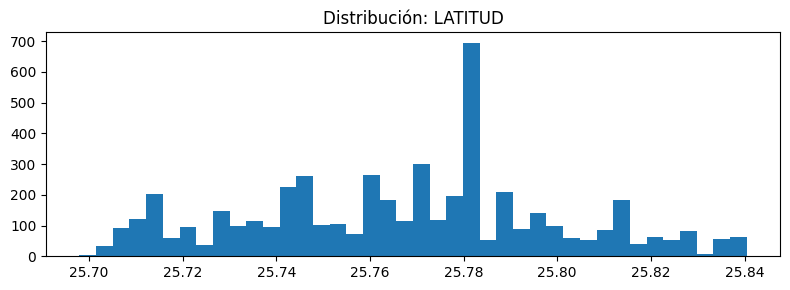

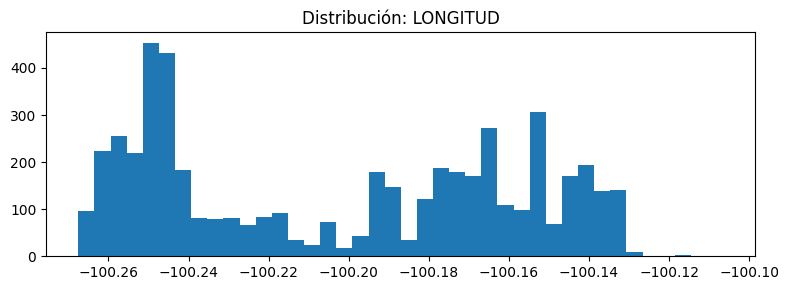

In [47]:
# Resumen numérico rápido
print(geotest_coordinates[["LATITUD","LONGITUD","MIN_DESDE_MEDIANOCHE"]].describe())

# Histogramas simples
plt.figure(figsize=(8,3)); plt.hist(geotest_coordinates["MIN_DESDE_MEDIANOCHE"], bins=48)
plt.title("Distribución: minutos desde medianoche"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3)); plt.hist(geotest_coordinates["LATITUD"], bins=40)
plt.title("Distribución: LATITUD"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3)); plt.hist(geotest_coordinates["LONGITUD"], bins=40)
plt.title("Distribución: LONGITUD"); plt.tight_layout(); plt.show()

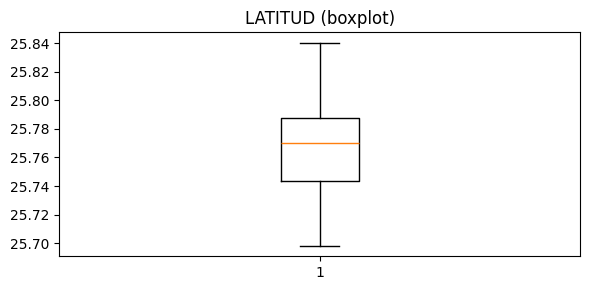

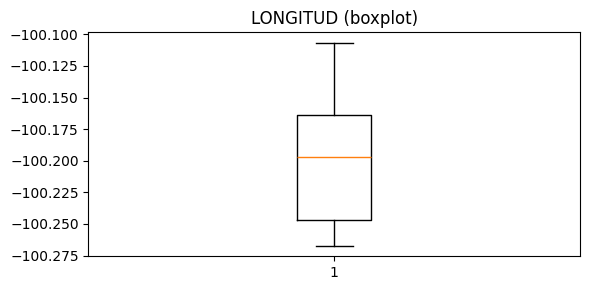

In [48]:
plt.figure(figsize=(6,3)); plt.boxplot(geotest_coordinates["LATITUD"].dropna()); plt.title("LATITUD (boxplot)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3)); plt.boxplot(geotest_coordinates["LONGITUD"].dropna()); plt.title("LONGITUD (boxplot)")
plt.tight_layout(); plt.show()

In [49]:
def iqr_outliers(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (s < lo) | (s > hi)

out_lat = iqr_outliers(geotest_coordinates["LATITUD"])
out_lon = iqr_outliers(geotest_coordinates["LONGITUD"])
df_out = geotest_coordinates[out_lat | out_lon]
print("Posibles outliers geográficos:", len(df_out))

Posibles outliers geográficos: 0


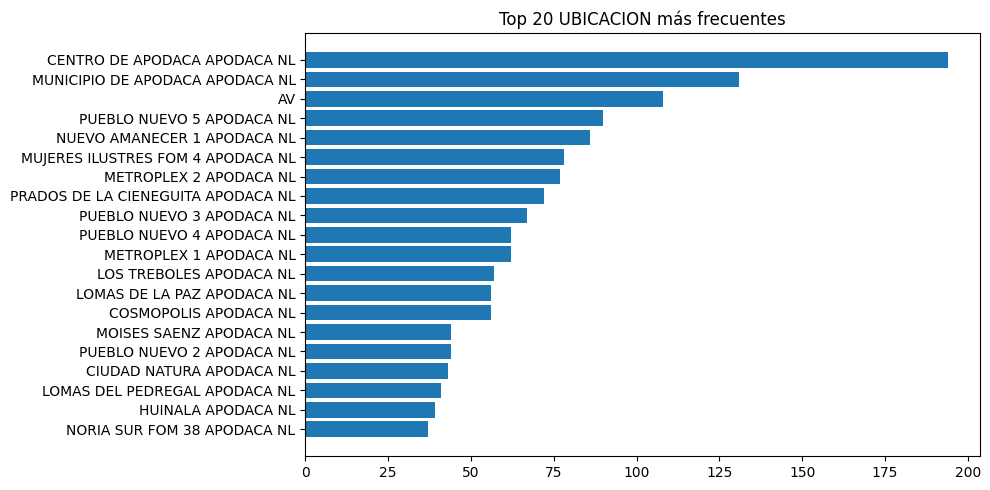

In [50]:
# Top ubicaciones (direcciones repetidas) – ajusta N según convenga
topN = 20
counts_ubi = geotest_coordinates["UBICACION"].value_counts().head(topN)

plt.figure(figsize=(10,5))
plt.barh(counts_ubi.index[::-1], counts_ubi.values[::-1])
plt.title(f"Top {topN} UBICACION más frecuentes")
plt.tight_layout(); plt.show()

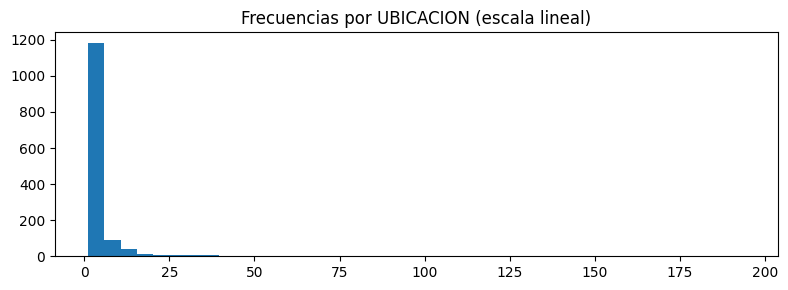

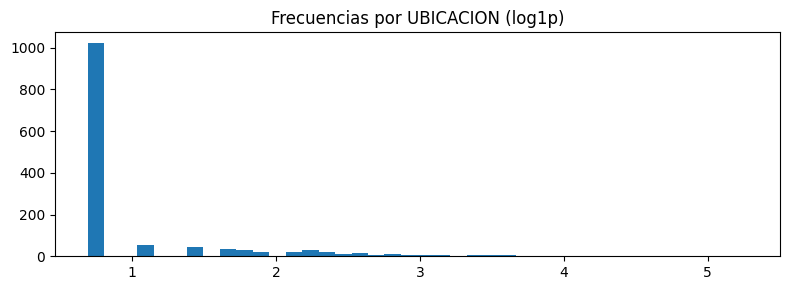

In [51]:
freq = geotest_coordinates["UBICACION"].value_counts()
plt.figure(figsize=(8,3)); plt.hist(freq.values, bins=40)
plt.title("Frecuencias por UBICACION (escala lineal)"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3)); plt.hist(np.log1p(freq.values), bins=40)
plt.title("Frecuencias por UBICACION (log1p)"); plt.tight_layout(); plt.show()


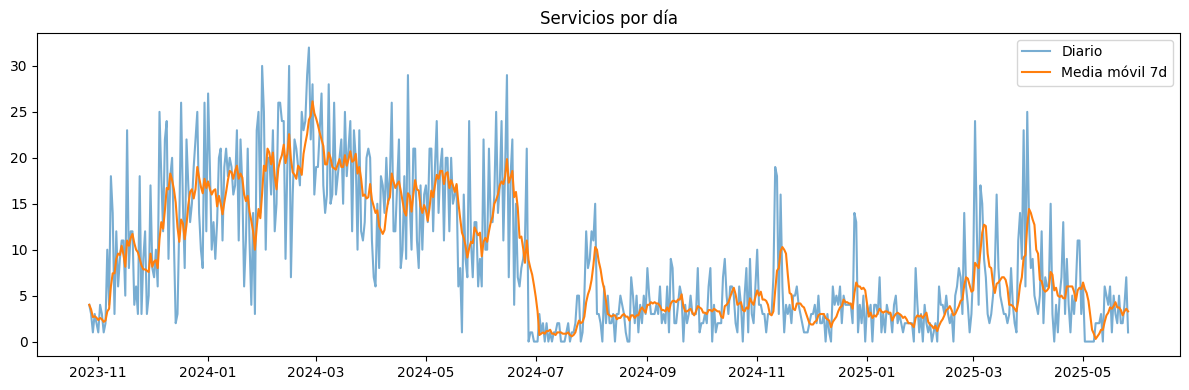

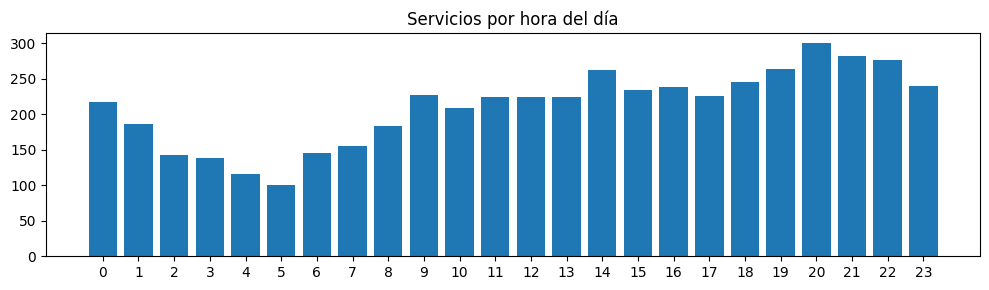

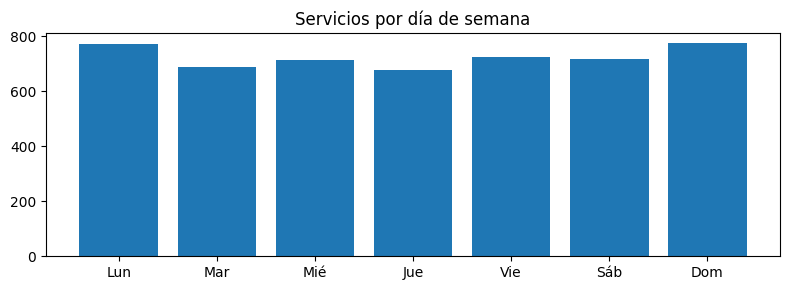

In [52]:
# Conteos diarios + media móvil 7d
daily = geotest_coordinates.set_index("DT_15").resample("D").size()
roll7 = daily.rolling(7, min_periods=1).mean()

plt.figure(figsize=(12,4))
plt.plot(daily.index, daily.values, label="Diario", alpha=0.6)
plt.plot(roll7.index, roll7.values, label="Media móvil 7d")
plt.title("Servicios por día"); plt.legend(); plt.tight_layout(); plt.show()

# Perfil por hora (24 barras)
hour_counts = geotest_coordinates["HORA_H"].value_counts().sort_index()
plt.figure(figsize=(10,3))
plt.bar(hour_counts.index, hour_counts.values)
plt.title("Servicios por hora del día"); plt.xticks(range(24)); plt.tight_layout(); plt.show()

# Estacionalidad semanal (promedio por weekday)
wk = geotest_coordinates.groupby("WEEKDAY_NAME").size().reindex(["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"])
plt.figure(figsize=(8,3))
plt.bar(np.arange(len(wk)), wk.values)
plt.title("Servicios por día de semana")
plt.xticks(np.arange(len(wk)), wk.index); plt.tight_layout(); plt.show()

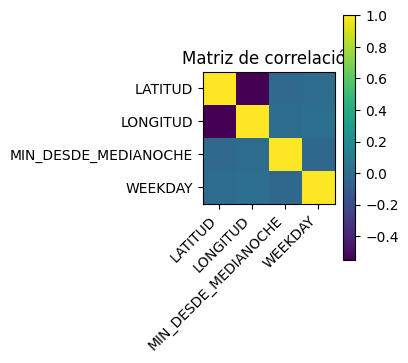

In [53]:
num = geotest_coordinates[["LATITUD","LONGITUD","MIN_DESDE_MEDIANOCHE","WEEKDAY"]].dropna()
corr = num.corr()

plt.figure(figsize=(4,4))
plt.imshow(corr.values, aspect="equal")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha="right")
plt.yticks(range(corr.shape[1]), corr.columns)
plt.title("Matriz de correlación")
plt.colorbar(); plt.tight_layout(); plt.show()

/tmp/ipython-input-1085290084.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = (geotest_coordinates.pivot_table(index="WEEKDAY_NAME", columns="HORA_15",


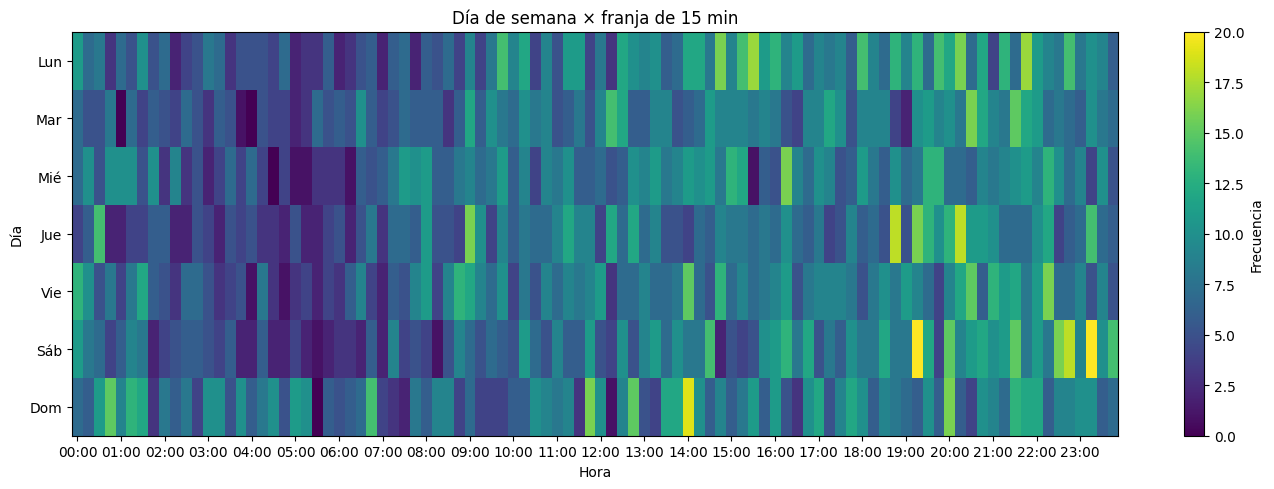

In [54]:
slots = pd.date_range("00:00","23:45",freq="15min").strftime("%H:%M")
pivot = (geotest_coordinates.pivot_table(index="WEEKDAY_NAME", columns="HORA_15",
                        values="FECHA", aggfunc="size", fill_value=0)
         .reindex(index=["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"])
         .reindex(columns=slots))

plt.figure(figsize=(14,5))
im = plt.imshow(pivot.values, aspect="auto", origin="upper")
plt.title("Día de semana × franja de 15 min"); plt.xlabel("Hora"); plt.ylabel("Día")
ticks = np.arange(0, 96, 4)
plt.xticks(ticks, slots[ticks]); plt.yticks(range(7), pivot.index)
plt.colorbar(im, label="Frecuencia"); plt.tight_layout(); plt.show()

/tmp/ipython-input-1360144327.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"], showfliers=False)


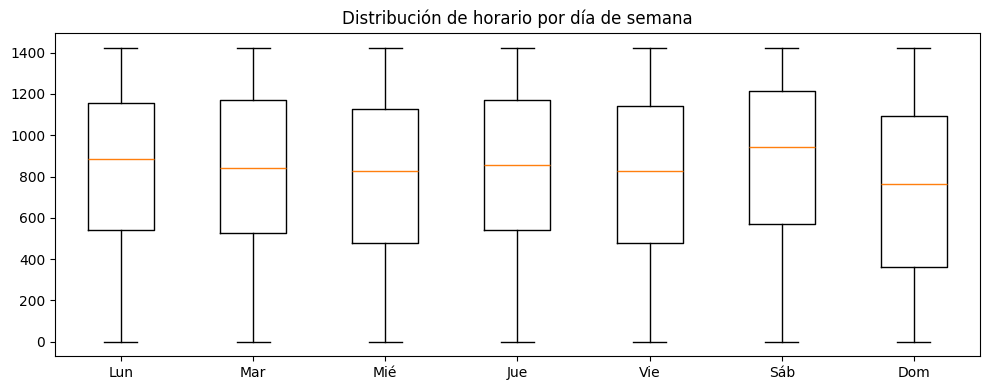

In [55]:
data = [geotest_coordinates.loc[geotest_coordinates["WEEKDAY_NAME"]==d,"MIN_DESDE_MEDIANOCHE"]
        for d in ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]]
plt.figure(figsize=(10,4))
plt.boxplot(data, labels=["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"], showfliers=False)
plt.title("Distribución de horario por día de semana")
plt.tight_layout(); plt.show()

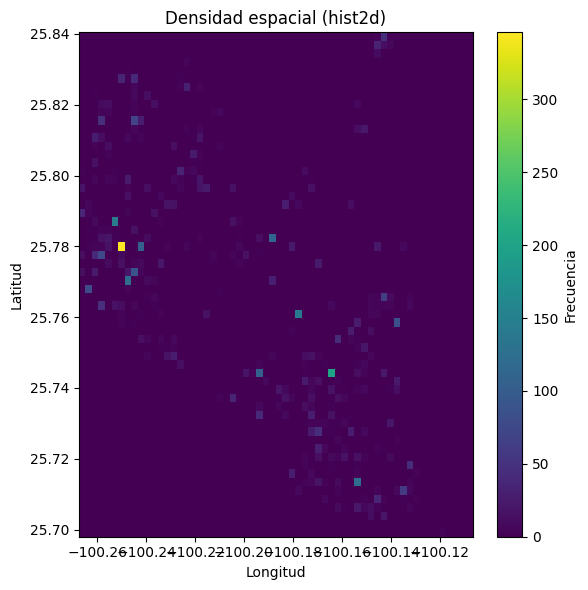

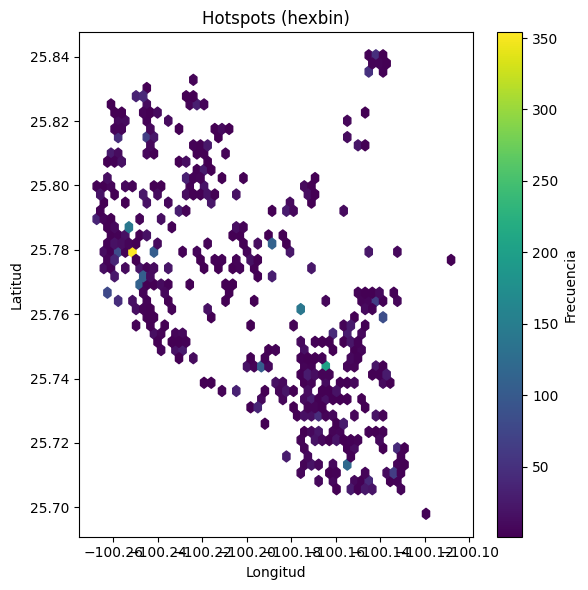

In [56]:
# Mapa de densidad simple con hist2d (sin mapas base)
plt.figure(figsize=(6,6))
plt.hist2d(geotest_coordinates["LONGITUD"], geotest_coordinates["LATITUD"], bins=60)
plt.title("Densidad espacial (hist2d)"); plt.xlabel("Longitud"); plt.ylabel("Latitud")
plt.colorbar(label="Frecuencia"); plt.tight_layout(); plt.show()

# Hexbin (suave y útil para hotspots)
plt.figure(figsize=(6,6))
plt.hexbin(geotest_coordinates["LONGITUD"], geotest_coordinates["LATITUD"], gridsize=50, mincnt=1)
plt.title("Hotspots (hexbin)"); plt.xlabel("Longitud"); plt.ylabel("Latitud")
plt.colorbar(label="Frecuencia"); plt.tight_layout(); plt.show()

Duplicados (DT_15, lat, lon): 40


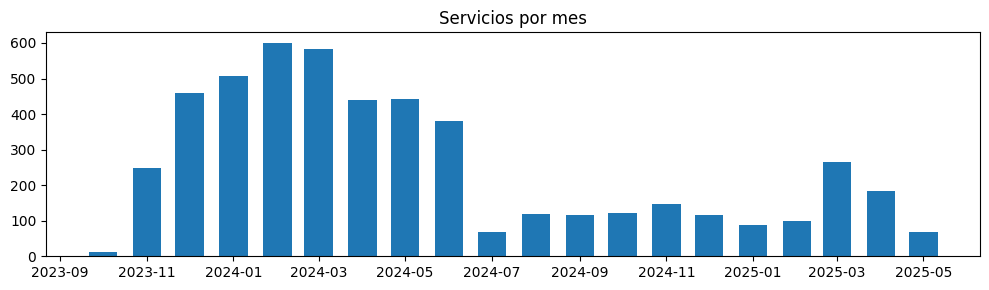

In [57]:
dups = geotest_coordinates.duplicated(subset=["DT_15","LATITUD","LONGITUD"], keep=False)
print("Duplicados (DT_15, lat, lon):", dups.sum())

# Visual rápido de cargas por mes (para revisar picos anómalos)
monthly = geotest_coordinates.set_index("DT_15").resample("MS").size()
plt.figure(figsize=(10,3))
plt.bar(monthly.index, monthly.values, width=20)  # barra ancha tipo “mes”
plt.title("Servicios por mes"); plt.tight_layout(); plt.show()


In [58]:

df = geotest_coordinates.copy()

# Redondea a 4 decimales ≈ 11 m lat / ~10 m lon en Apodaca
DEC = 4
df["LAT_r"] = df["LATITUD"].round(DEC)
df["LON_r"] = df["LONGITUD"].round(DEC)
df["CELL"]  = df["LAT_r"].astype(str) + "," + df["LON_r"].astype(str)  # id de celda

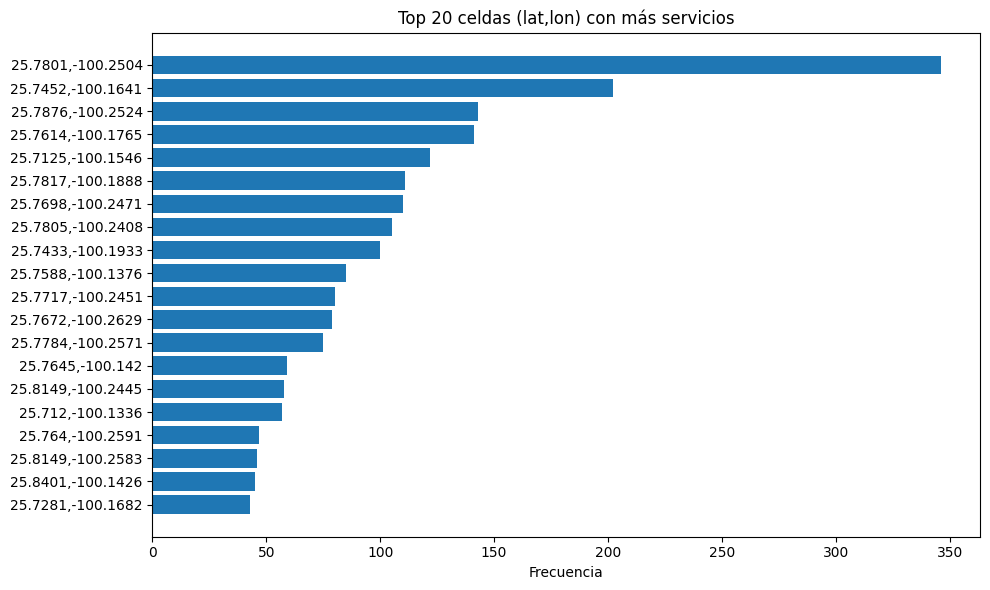

Celdas únicas totales: 742


In [59]:
topN = 20
cell_counts = df["CELL"].value_counts()
top_cells   = cell_counts.head(topN)

plt.figure(figsize=(10,6))
plt.barh(top_cells.index[::-1], top_cells.values[::-1])
plt.title(f"Top {topN} celdas (lat,lon) con más servicios")
plt.xlabel("Frecuencia"); plt.tight_layout(); plt.show()

print("Celdas únicas totales:", df["CELL"].nunique())


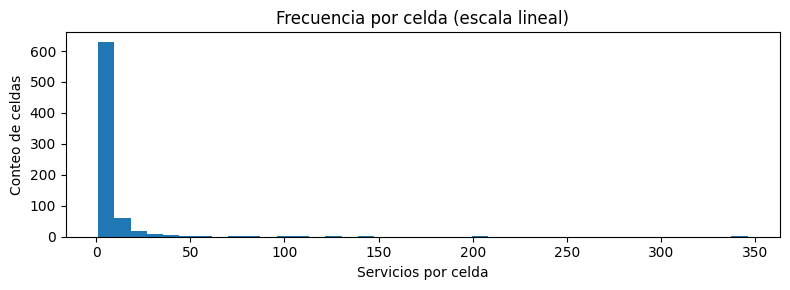

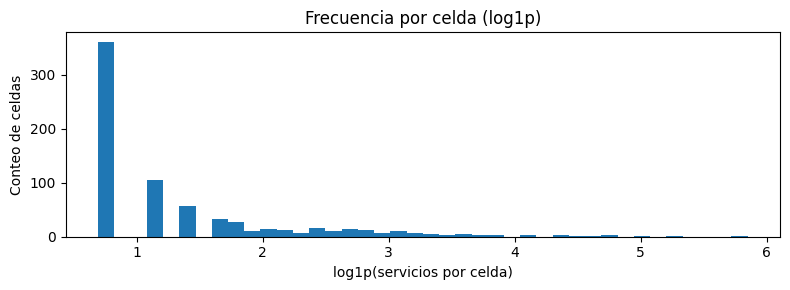

In [60]:
freq = cell_counts.values  # frecuencia por celda
plt.figure(figsize=(8,3)); plt.hist(freq, bins=40)
plt.title("Frecuencia por celda (escala lineal)")
plt.xlabel("Servicios por celda"); plt.ylabel("Conteo de celdas")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3)); plt.hist(np.log1p(freq), bins=40)
plt.title("Frecuencia por celda (log1p)")
plt.xlabel("log1p(servicios por celda)"); plt.ylabel("Conteo de celdas")
plt.tight_layout(); plt.show()


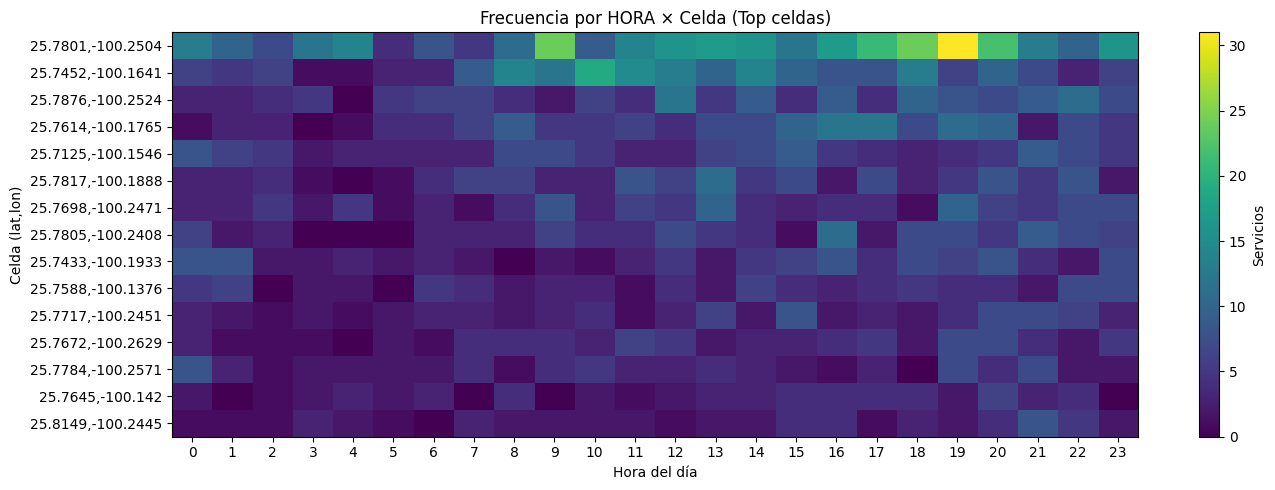

In [61]:
# Tabla hora (0..23) × celda (Top K)
K = 15
cells_to_show = cell_counts.head(K).index
hour_cell = (df.groupby(["HORA_H","CELL"]).size()
               .unstack(fill_value=0)
               .reindex(index=range(24), fill_value=0))[cells_to_show]

plt.figure(figsize=(14,5))
im = plt.imshow(hour_cell.values.T, aspect="auto", origin="upper")
plt.title("Frecuencia por HORA × Celda (Top celdas)")
plt.xlabel("Hora del día"); plt.ylabel("Celda (lat,lon)")
plt.xticks(range(24), range(24))
plt.yticks(range(K), cells_to_show)
plt.colorbar(im, label="Servicios"); plt.tight_layout(); plt.show()


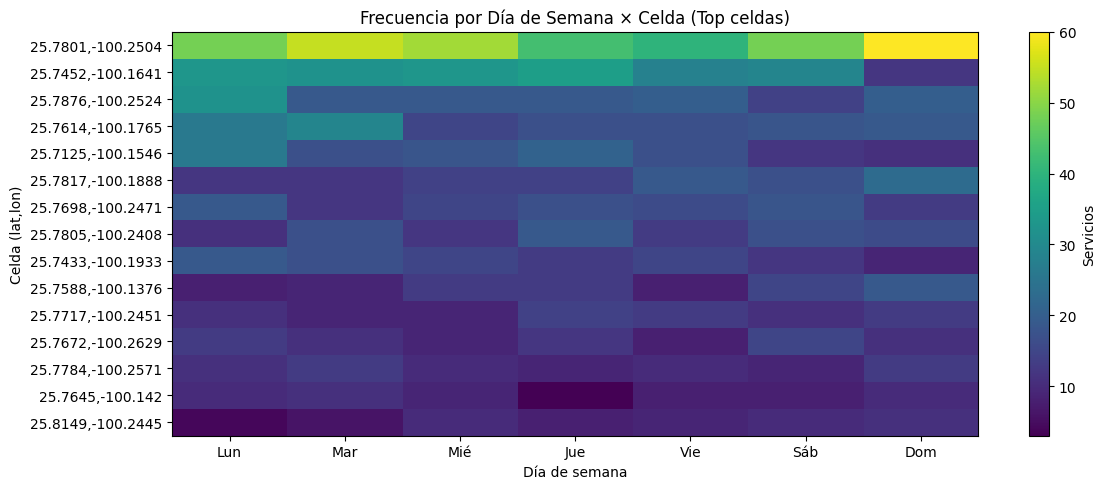

In [62]:
weekday_order = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
wk_cell = (df.groupby(["WEEKDAY_NAME","CELL"]).size()
             .unstack(fill_value=0)
             .reindex(index=weekday_order))[cells_to_show]

plt.figure(figsize=(12,5))
im = plt.imshow(wk_cell.values.T, aspect="auto", origin="upper")
plt.title("Frecuencia por Día de Semana × Celda (Top celdas)")
plt.xlabel("Día de semana"); plt.ylabel("Celda (lat,lon)")
plt.xticks(range(7), weekday_order)
plt.yticks(range(K), cells_to_show)
plt.colorbar(im, label="Servicios"); plt.tight_layout(); plt.show()


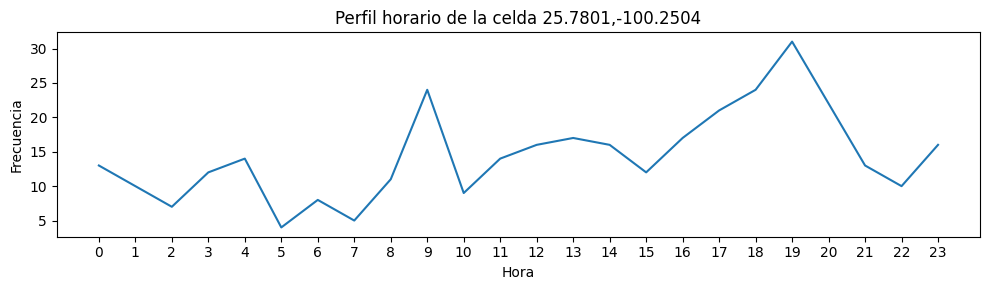

In [63]:
def plot_cell_hour_profile(cell_id):
    s = df.loc[df["CELL"]==cell_id, "HORA_H"].value_counts().sort_index()
    s = s.reindex(range(24), fill_value=0)
    plt.figure(figsize=(10,3))
    plt.plot(s.index, s.values)
    plt.title(f"Perfil horario de la celda {cell_id}")
    plt.xlabel("Hora"); plt.ylabel("Frecuencia")
    plt.xticks(range(24)); plt.tight_layout(); plt.show()

# Ejemplo: primera celda del Top
plot_cell_hour_profile(top_cells.index[0])


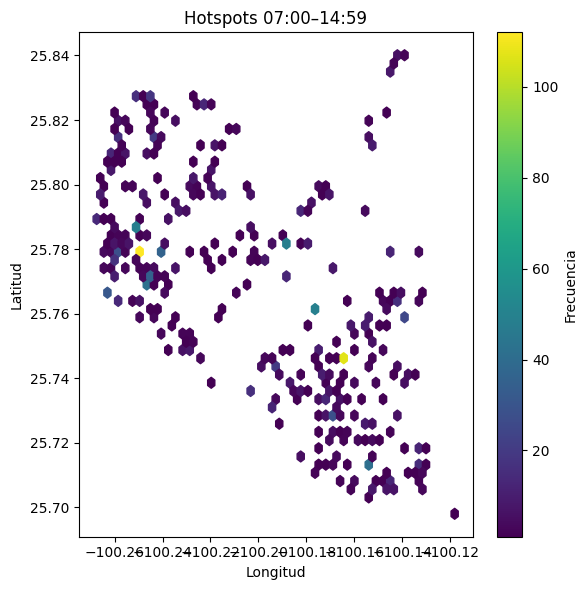

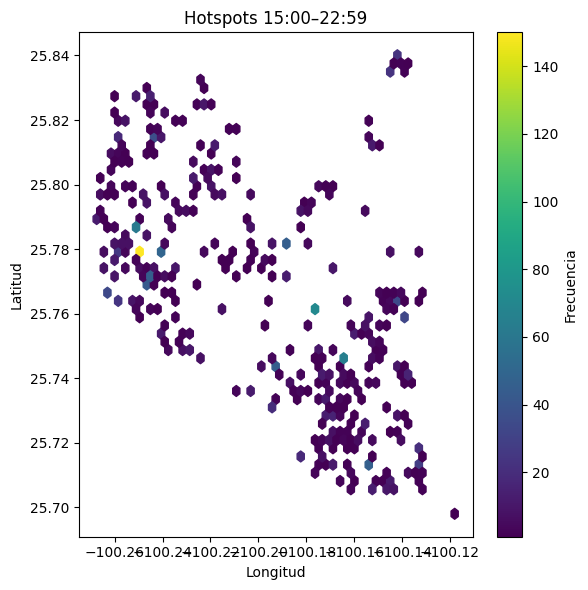

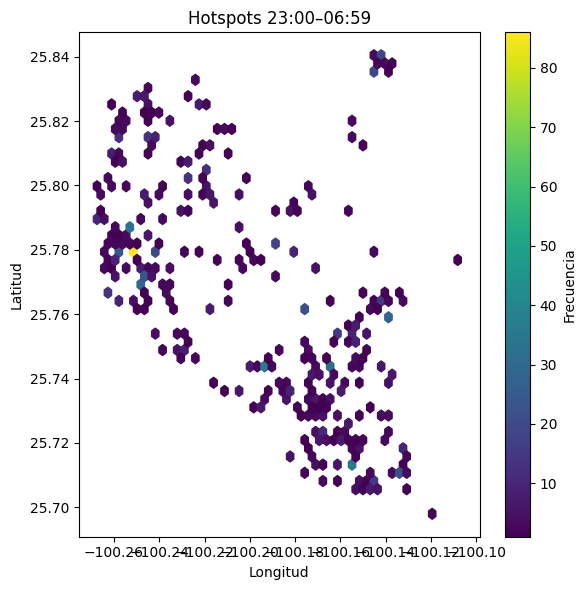

In [64]:
def hexbin_por_franja(mask, titulo, gridsize=50):
    sub = df[mask]
    plt.figure(figsize=(6,6))
    plt.hexbin(sub["LONGITUD"], sub["LATITUD"], gridsize=gridsize, mincnt=1)
    plt.title(titulo); plt.xlabel("Longitud"); plt.ylabel("Latitud")
    plt.colorbar(label="Frecuencia"); plt.tight_layout(); plt.show()

hexbin_por_franja((df["HORA_H"]>=7)&(df["HORA_H"]<15), "Hotspots 07:00–14:59")
hexbin_por_franja((df["HORA_H"]>=15)&(df["HORA_H"]<23), "Hotspots 15:00–22:59")
hexbin_por_franja((df["HORA_H"]<7)|(df["HORA_H"]>=23), "Hotspots 23:00–06:59")


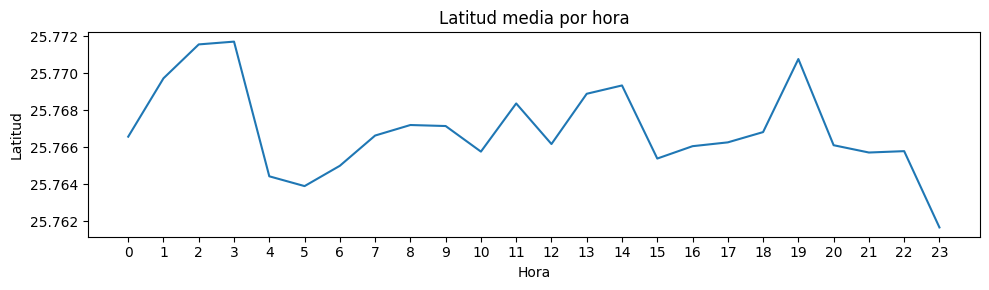

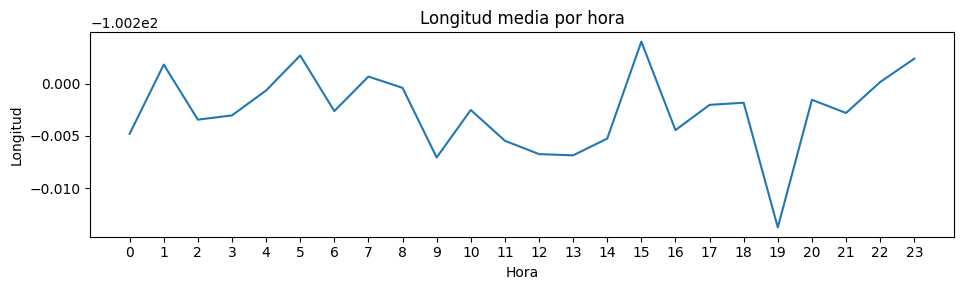

In [65]:
cent = df.groupby("HORA_H")[["LATITUD","LONGITUD"]].mean()

plt.figure(figsize=(10,3))
plt.plot(cent.index, cent["LATITUD"].values)
plt.title("Latitud media por hora"); plt.xlabel("Hora"); plt.ylabel("Latitud")
plt.xticks(range(24)); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(cent.index, cent["LONGITUD"].values)
plt.title("Longitud media por hora"); plt.xlabel("Hora"); plt.ylabel("Longitud")
plt.xticks(range(24)); plt.tight_layout(); plt.show()


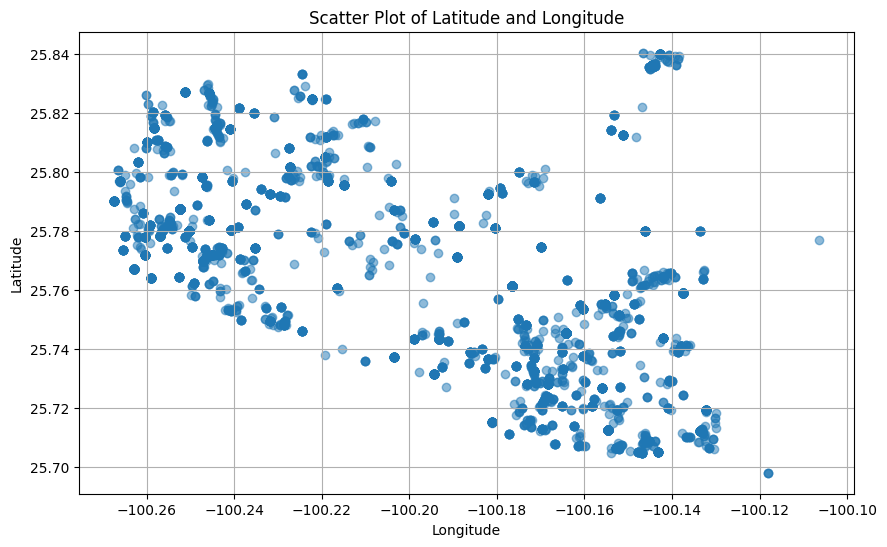

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(geotest_coordinates['LONGITUD'], geotest_coordinates['LATITUD'], alpha=0.5)
plt.title('Scatter Plot of Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

#**Conclusiones del EDA:**
- Se confirmaron valores faltantes iniciales, que fueron eliminados; no quedaron patrones de ausencia relevantes.
- Se identificaron outliers en coordenadas y se aplicó filtrado para depurarlos.
- La variable `UBICACION` presenta alta cardinalidad, aunque con concentración en ciertos puntos.
- Existen distribuciones sesgadas en algunas variables numéricas (ej. minutos desde medianoche).
- Se detectaron tendencias temporales con picos en ciertos días y horarios.
- Se observó un desbalance espacial: pocas celdas concentran gran parte de los servicios.